In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data

Define the Trainset and Testset. The dataset was splited randomly to the trainset and test set.

In [2]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))],)


batch_size = 40

dataset = torchvision.datasets.SEMEION(root='./data', 
                                      download=True, transform=transform)

trainset, testset = torch.utils.data.random_split(dataset, [1000,593])


# Load the trainset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Load the testset
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9')

Files already downloaded and verified


Let us show some of the training images.

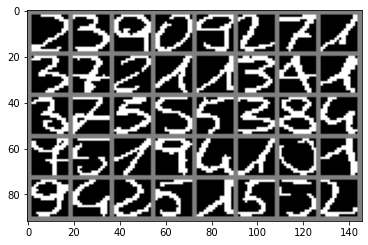

2     3     9     0     9     2     7     1     3     7     2     1     1     3     4     1     3     7     5     5     5     3     8     4     7     5     1     9     4     1     0     1     9     4     2     5     1     5     5     2    


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Model 1: CNN model with 1 Convolutional layer and SGD as optimizer.

In [4]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4 * 7 * 7, 180)
        self.fc2 = nn.Linear(180, 90)
        self.fc3 = nn.Linear(90, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_1 = Net()
net_1 = net_1.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_1.parameters(), lr=0.001, momentum=0.9)

In [5]:
n_epochs = 80
all_acc_1 = []
train_acc_1 = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net_1.to('cuda')
    net_1.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_1.append(train_acc.cpu().item())
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] , Accuracy of Training data = {train_acc:.5f}")
            
    net_1.eval()
    net_1.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_1(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_1.append(acc)
    print(f'Accuracy of Test data = {100 * correct // total} %')
print('Finished Training')

[ Train | 001/080 ] , Accuracy of Training data = 0.08100
Accuracy of Test data = 8 %
[ Train | 002/080 ] , Accuracy of Training data = 0.08500
Accuracy of Test data = 9 %
[ Train | 003/080 ] , Accuracy of Training data = 0.09300
Accuracy of Test data = 9 %
[ Train | 004/080 ] , Accuracy of Training data = 0.10400
Accuracy of Test data = 10 %
[ Train | 005/080 ] , Accuracy of Training data = 0.11900
Accuracy of Test data = 11 %
[ Train | 006/080 ] , Accuracy of Training data = 0.13700
Accuracy of Test data = 13 %
[ Train | 007/080 ] , Accuracy of Training data = 0.15900
Accuracy of Test data = 17 %
[ Train | 008/080 ] , Accuracy of Training data = 0.20800
Accuracy of Test data = 22 %
[ Train | 009/080 ] , Accuracy of Training data = 0.26200
Accuracy of Test data = 27 %
[ Train | 010/080 ] , Accuracy of Training data = 0.30200
Accuracy of Test data = 32 %
[ Train | 011/080 ] , Accuracy of Training data = 0.33900
Accuracy of Test data = 34 %
[ Train | 012/080 ] , Accuracy of Training dat

In [6]:
PATH1 = './cifar_net.pth'
torch.save(net_1.state_dict(), PATH1)

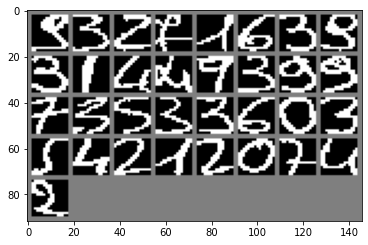

Predicted:  9     3     2     4     1     6     3     9     3     1     4     4     9     3     9     9     7     9     5     3     3     6     0     3     5     4     2     1     2     0     7     4     2    


In [7]:
net_1 = Net()
net_1.load_state_dict(torch.load(PATH1))

outputs = net_1(images)

_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(predicted.size(dim=0))))


In [8]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_1(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Net_1 on all test images: {100 * correct // total} %')

Accuracy of Net_1 on all test images: 92 %


In [9]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_1(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 94.4 %
Accuracy for class: 1     is 96.4 %
Accuracy for class: 2     is 94.7 %
Accuracy for class: 3     is 88.9 %
Accuracy for class: 4     is 91.2 %
Accuracy for class: 5     is 96.4 %
Accuracy for class: 6     is 95.0 %
Accuracy for class: 7     is 90.0 %
Accuracy for class: 8     is 93.5 %
Accuracy for class: 9     is 89.8 %


Model 2: Simple neural network with only full connected layers.

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1 * 16 * 16, 180)
        self.fc2 = nn.Linear(180, 90)
        self.fc3 = nn.Linear(90, 10)


    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_2 = Net()
net_2 = net_2.to ('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_2.parameters(), lr=0.001, momentum=0.9)

In [11]:
n_epochs = 80
all_acc_2 = []
train_acc_2 = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net_2.to('cuda')
    net_2.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_2.append(train_acc.cpu().item())
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] , Accuracy of Training data = {train_acc:.5f}")
            
    net_2.eval()
    net_2.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_2(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_2.append(acc)
    print(f'Accuracy of Test data = {100 * correct // total} %')
print('Finished Training')

[ Train | 001/080 ] , Accuracy of Training data = 0.14600
Accuracy of Test data = 17 %
[ Train | 002/080 ] , Accuracy of Training data = 0.19800
Accuracy of Test data = 22 %
[ Train | 003/080 ] , Accuracy of Training data = 0.26000
Accuracy of Test data = 30 %
[ Train | 004/080 ] , Accuracy of Training data = 0.33400
Accuracy of Test data = 37 %
[ Train | 005/080 ] , Accuracy of Training data = 0.40200
Accuracy of Test data = 46 %
[ Train | 006/080 ] , Accuracy of Training data = 0.50000
Accuracy of Test data = 53 %
[ Train | 007/080 ] , Accuracy of Training data = 0.57300
Accuracy of Test data = 60 %
[ Train | 008/080 ] , Accuracy of Training data = 0.63700
Accuracy of Test data = 65 %
[ Train | 009/080 ] , Accuracy of Training data = 0.68500
Accuracy of Test data = 68 %
[ Train | 010/080 ] , Accuracy of Training data = 0.72200
Accuracy of Test data = 71 %
[ Train | 011/080 ] , Accuracy of Training data = 0.74400
Accuracy of Test data = 73 %
[ Train | 012/080 ] , Accuracy of Training 

In [12]:
PATH2 = './cifar_net.pth'
torch.save(net_2.state_dict(), PATH2)

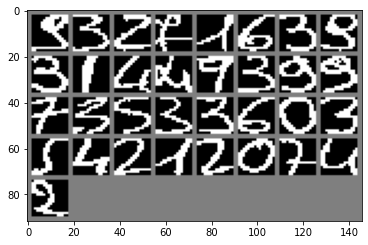

Predicted:  9     3     2     6     1     6     3     9     3     1     4     4     9     3     9     9     7     3     5     3     3     6     0     3     5     4     2     1     2     0     7     4     2    


In [13]:
net_2 = Net()
net_2.load_state_dict(torch.load(PATH2))

outputs = net_2(images)

_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(predicted.size(dim=0))))


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Net_2 on all test images: {100 * correct // total} %')

Accuracy of Net_2 on all test images: 91 %


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 98.1 %
Accuracy for class: 1     is 94.5 %
Accuracy for class: 2     is 91.2 %
Accuracy for class: 3     is 88.9 %
Accuracy for class: 4     is 89.5 %
Accuracy for class: 5     is 91.1 %
Accuracy for class: 6     is 98.3 %
Accuracy for class: 7     is 85.7 %
Accuracy for class: 8     is 95.2 %
Accuracy for class: 9     is 84.7 %


Model 3: CNN model with 2 Convolutional layers and SGD as optimizer.

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 2)
        self.fc1 = nn.Linear(8 * 3 * 3, 180)
        self.fc2 = nn.Linear(180, 90)
        self.fc3 = nn.Linear(90, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_3 = Net()
net_3 = net_3.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_3.parameters(), lr=0.001, momentum=0.9)

In [17]:
n_epochs = 80
all_acc_3 = []
train_acc_3 = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net_3.to('cuda')
    net_3.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_3.append(train_acc.cpu().item())
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] , Accuracy of Training data = {train_acc:.5f}")
            
    net_3.eval()
    net_3.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_3(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_3.append(acc)
    print(f'Accuracy of Test data = {100 * correct // total} %')
print('Finished Training')

[ Train | 001/080 ] , Accuracy of Training data = 0.08200
Accuracy of Test data = 8 %
[ Train | 002/080 ] , Accuracy of Training data = 0.08400
Accuracy of Test data = 8 %
[ Train | 003/080 ] , Accuracy of Training data = 0.07800
Accuracy of Test data = 8 %
[ Train | 004/080 ] , Accuracy of Training data = 0.09200
Accuracy of Test data = 10 %
[ Train | 005/080 ] , Accuracy of Training data = 0.12100
Accuracy of Test data = 12 %
[ Train | 006/080 ] , Accuracy of Training data = 0.17000
Accuracy of Test data = 15 %
[ Train | 007/080 ] , Accuracy of Training data = 0.22300
Accuracy of Test data = 18 %
[ Train | 008/080 ] , Accuracy of Training data = 0.23900
Accuracy of Test data = 21 %
[ Train | 009/080 ] , Accuracy of Training data = 0.25600
Accuracy of Test data = 23 %
[ Train | 010/080 ] , Accuracy of Training data = 0.25900
Accuracy of Test data = 22 %
[ Train | 011/080 ] , Accuracy of Training data = 0.25600
Accuracy of Test data = 21 %
[ Train | 012/080 ] , Accuracy of Training dat

In [18]:
PATH3 = './cifar_net.pth'
torch.save(net_3.state_dict(), PATH3)

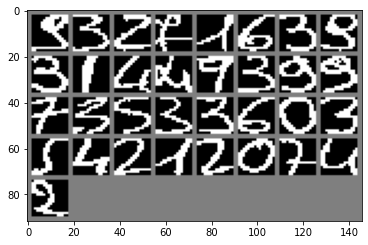

Predicted:  9     3     2     4     1     6     3     9     3     6     4     6     9     3     2     9     1     3     5     3     3     6     0     3     1     4     2     1     2     0     7     0     2    


In [19]:
net_3 = Net()
net_3.load_state_dict(torch.load(PATH2))

outputs = net_3(images)

_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(predicted.size(dim=0))))

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_3(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Net_3 on all test images: {100 * correct // total} %')

Accuracy of Net_3 on all test images: 82 %


In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_3(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 92.6 %
Accuracy for class: 1     is 83.6 %
Accuracy for class: 2     is 94.7 %
Accuracy for class: 3     is 87.3 %
Accuracy for class: 4     is 66.7 %
Accuracy for class: 5     is 89.3 %
Accuracy for class: 6     is 91.7 %
Accuracy for class: 7     is 64.3 %
Accuracy for class: 8     is 80.6 %
Accuracy for class: 9     is 74.6 %


Model 4: CNN model with 1 Convolutional layer and ASGD as optimizer.

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4 * 7 * 7, 180)
        self.fc2 = nn.Linear(180, 90)
        self.fc3 = nn.Linear(90, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_4 = Net()
net_4 = net_4.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.ASGD(net_4.parameters(), lr=0.001)

In [23]:
n_epochs = 80
all_acc_4 = []
train_acc_4 = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net_4.to('cuda')
    net_4.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_4.append(train_acc.cpu().item())
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] , Accuracy of Training data = {train_acc:.5f}")
            
    net_4.eval()
    net_4.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_4(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_4.append(acc)
    print(f'Accuracy of Test data = {100 * correct // total} %')
print('Finished Training')

[ Train | 001/080 ] , Accuracy of Training data = 0.13400
Accuracy of Test data = 11 %
[ Train | 002/080 ] , Accuracy of Training data = 0.13600
Accuracy of Test data = 12 %
[ Train | 003/080 ] , Accuracy of Training data = 0.13900
Accuracy of Test data = 12 %
[ Train | 004/080 ] , Accuracy of Training data = 0.14100
Accuracy of Test data = 12 %
[ Train | 005/080 ] , Accuracy of Training data = 0.14300
Accuracy of Test data = 12 %
[ Train | 006/080 ] , Accuracy of Training data = 0.14600
Accuracy of Test data = 13 %
[ Train | 007/080 ] , Accuracy of Training data = 0.15000
Accuracy of Test data = 13 %
[ Train | 008/080 ] , Accuracy of Training data = 0.15200
Accuracy of Test data = 13 %
[ Train | 009/080 ] , Accuracy of Training data = 0.15500
Accuracy of Test data = 13 %
[ Train | 010/080 ] , Accuracy of Training data = 0.15900
Accuracy of Test data = 13 %
[ Train | 011/080 ] , Accuracy of Training data = 0.16100
Accuracy of Test data = 14 %
[ Train | 012/080 ] , Accuracy of Training 

In [24]:
PATH4 = './cifar_net.pth'
torch.save(net_4.state_dict(), PATH4)

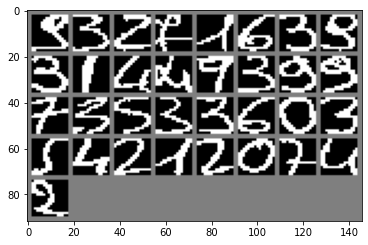

Predicted:  9     6     6     6     1     6     9     9     6     6     4     4     9     9     9     9     6     6     9     6     9     6     0     9     6     4     6     1     6     0     1     4     9    


In [25]:
net_4 = Net()
net_4.load_state_dict(torch.load(PATH4))

outputs = net_4(images)

_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(predicted.size(dim=0))))

In [26]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_4(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of Net_4 on all test images: {100 * correct // total} %')

Accuracy of Net_4 on all test images: 38 %


In [27]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_4(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 94.4 %
Accuracy for class: 1     is 54.5 %
Accuracy for class: 2     is 0.0 %
Accuracy for class: 3     is 0.0 %
Accuracy for class: 4     is 78.9 %
Accuracy for class: 5     is 0.0 %
Accuracy for class: 6     is 83.3 %
Accuracy for class: 7     is 0.0 %
Accuracy for class: 8     is 0.0 %
Accuracy for class: 9     is 84.7 %


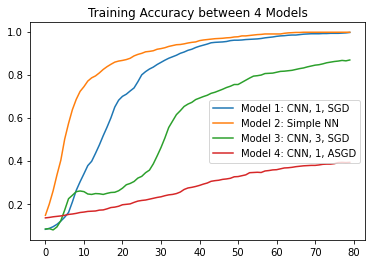

In [28]:
plt.plot(train_acc_1)
plt.plot(train_acc_2)
plt.plot(train_acc_3)
plt.plot(train_acc_4)
plt.legend(['Model 1: CNN, 1, SGD','Model 2: Simple NN', 'Model 3: CNN, 3, SGD', 'Model 4: CNN, 1, ASGD'])
plt.title('Training Accuracy between 4 Models')
plt.show()

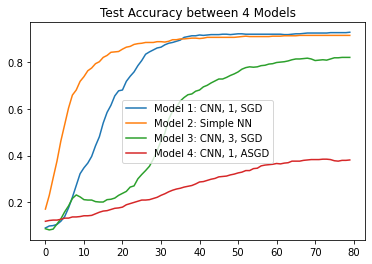

In [31]:
plt.plot(all_acc_1)
plt.plot(all_acc_2)
plt.plot(all_acc_3)
plt.plot(all_acc_4)
plt.legend(['Model 1: CNN, 1, SGD','Model 2: Simple NN', 'Model 3: CNN, 3, SGD', 'Model 4: CNN, 1, ASGD'])
plt.title('Test Accuracy between 4 Models')
plt.show()